In [1]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
from scipy.stats import norm, pearsonr

%matplotlib inline

In [2]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [3]:
def scale_to_extreme(arr, thr):
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    _arr = [arr_min if a < thr else arr_max for a in arr]
    return _arr

In [4]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

Number of files:  2196
File: /home/othniel/wdml/Data/awdEvents1/marion_data/2013-07-31UT01:30:11.82051922.marion.vr2
[[2.99919946e+03 2.10000000e+01]
 [4.99930225e+03 8.70000000e+01]
 [4.99932227e+03 6.60000000e+01]
 [4.99954053e+03 1.00000000e+00]
 [4.99956152e+03 1.00000000e+01]
 [4.99972852e+03 7.70000000e+01]
 [4.99979346e+03 2.10000000e+01]
 [4.99983838e+03 9.00000000e+00]]


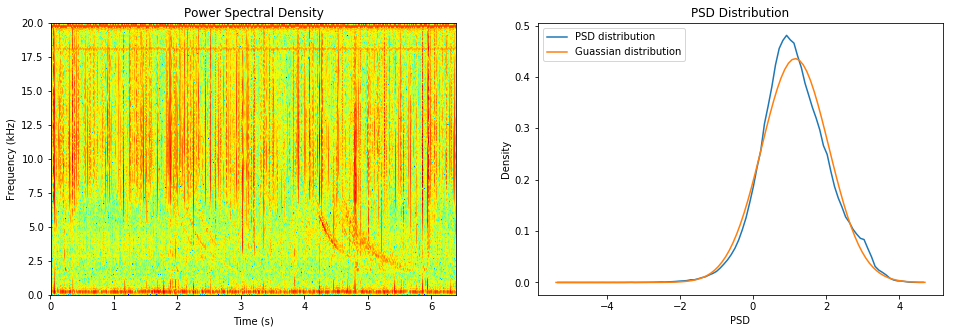

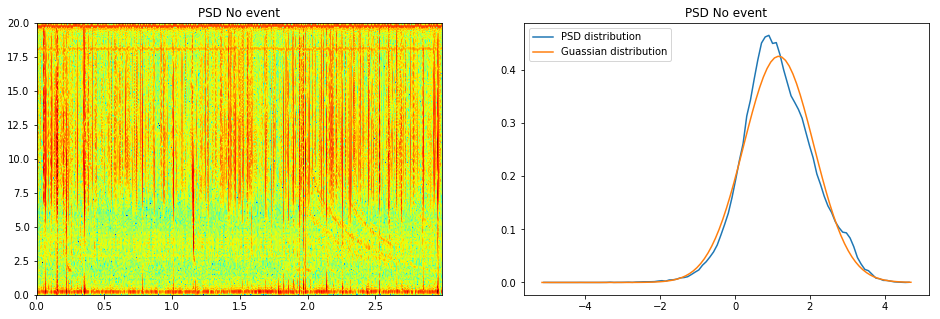

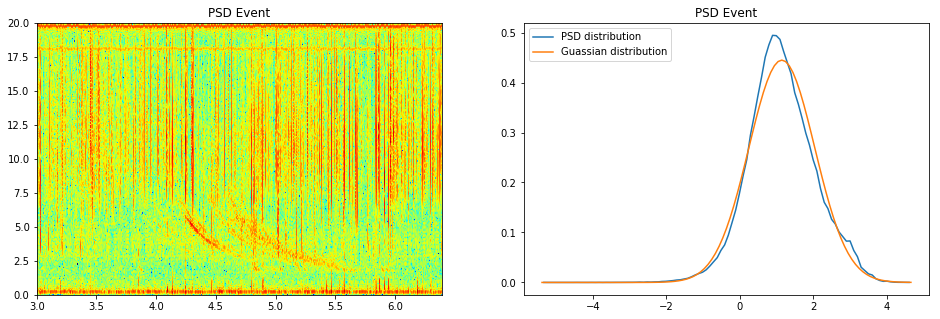

In [30]:
f  = h5py.File(database_path, 'r')
grp_wh = f[os.path.join('awdEvents'+str(1), sites[0],'labelled whistler traces')]
files = list(grp_wh.keys())
print('Number of files: ', len(files))
file = files[np.random.randint(len(files))] # select a random sample
# create np array to store sample information
whdf = np.empty(grp_wh[file].shape)
grp_wh[file].read_direct(whdf)
fs = grp_wh[file].attrs['sample frequency']
outputs = grp_wh[file].attrs['outputs']
events = grp_wh[file].attrs['events']
f.close()

# get spectrogram
f, t, Sxx = signal.spectrogram(whdf[:,0], fs=fs, detrend='linear', nfft=512 , noverlap=64, scaling='density',mode='psd')
# get first events
output = np.round(outputs[0][0]/1000,2)
# find index of that event in the spectrogram
_t = np.round_(t,decimals=2)
index = np.where(_t==output)[0][0]
# slip the spectrogram into two
Sxx_no_event, Sxx_event = np.hsplit(np.log10(Sxx), [index])
t_no_event, t_event = np.hsplit(t, [index])

mean_no_event, mean_event = np.mean(Sxx_no_event), np.mean(Sxx_event)
std_no_event, std_event = np.std(Sxx_no_event), np.std(Sxx_event)
# Compute histogram
(n_no_event, bins_no_event) = np.histogram(Sxx_no_event.flatten(), bins=100, density=True)
(n_event, bins_event) = np.histogram(Sxx_event.flatten(), bins=100, density=True)
# Compute pdf
pdf_no_event = norm.pdf(bins_no_event, mean_no_event, std_no_event)
pdf_event = norm.pdf(bins_event, mean_event, std_event)
# correlation between gaussian and pdf
corr_no_event = pearsonr(n_no_event,pdf_no_event[:-1])
corr_event = pearsonr(n_event,pdf_event[:-1])

print('File:', os.path.join(os.getcwd().split(os.environ.get('USER'))[0],
                            os.environ.get('USER'), 'wdml', 'Data','awdEvents'+str(1), sites[0]+'_data', file))

print(outputs)
##
Sxx_psd = np.log10(Sxx)
# get mean
mean = np.mean(Sxx_psd)
std = np.std(Sxx_psd)
# Compute histogram
(n, bins) = np.histogram(Sxx_psd.flatten(), bins=100, density=True)  # NumPy version (no plot)
# Compute pdf
pdf = norm.pdf(bins, mean, std)
# plot 
plt.figure(figsize=(16,5))
fig = plt.subplot(1,2,1)
img = plt.pcolormesh(t,f/1000,Sxx_psd, cmap='jet')
# fig.colorbar(mappable=img, label='Power [dB]')
plt.title('Power Spectral Density')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.subplot(1,2,2)
plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.plot(bins, pdf)
plt.title('PSD Distribution')
plt.xlabel('PSD')
plt.ylabel('Density')
plt.legend(['PSD distribution', 'Guassian distribution'])
plt.show()

# plot 
plt.figure(figsize=(16,5))
fig = plt.subplot(1,2,1)
plt.pcolormesh(t_no_event,f/1000,Sxx_no_event, cmap='jet')
plt.title('PSD No event')
plt.subplot(1,2,2)
plt.plot(.5*(bins_no_event[1:]+bins_no_event[:-1]), n_no_event)
plt.plot(bins_no_event, pdf_no_event)
plt.title('PSD No event')
plt.legend(['PSD distribution', 'Guassian distribution'])

plt.figure(figsize=(16,5))
fig = plt.subplot(1,2,1)
plt.pcolormesh(t_event,f/1000,Sxx_event, cmap='jet')
plt.title('PSD Event')
plt.subplot(1,2,2)
plt.plot(.5*(bins_event[1:]+bins_event[:-1]), n_event)
plt.plot(bins_event, pdf_event)
plt.title('PSD Event')
plt.legend(['PSD distribution', 'Guassian distribution'])
plt.show()